#  Прогнозирование заказов такси

Необходимо разработать модель, которая будет предсказывать количество заказов такси на один час вперед. Заказчиком является компания "Чётенькое такси". Модель необходима для увеличения числа водителей в период пиковой нагрузки.

Для работы предоставлены исторические данные о заказах такси в аэропортах.

Качество нужно оценить с помощью метрики RMSE. Её значение на тестовой выборке должно быть не больше 48.

**Описание данных**:

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце 'num_orders'.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-библиотек" data-toc-modified-id="Загрузка-данных-и-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и библиотек</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Prophet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Загрузка данных и библиотек

In [ ]:
!pip install prophet

In [1]:
# необходимые библиотеки
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from catboost import CatBoostRegressor
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet.diagnostics import performance_metrics, cross_validation

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# если можно, открываем файл из локального носителя
# или с Jupyter Hub
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.index.is_monotonic

True

Пропущенных значений нет. Колонка с временными значениями переведена в `datetime` и сделана индексом. Все данные расположены в хронологическом порядке.

In [5]:
df = df.resample('1H').sum()

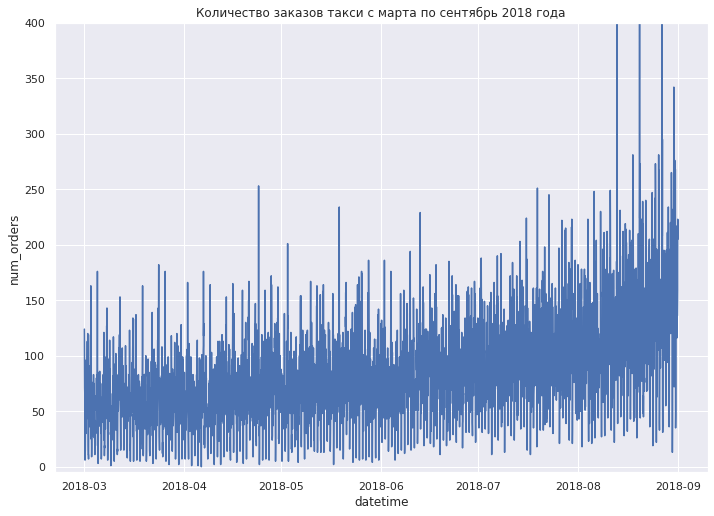

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ylim(-5,400)
plt.title("Количество заказов такси с марта по сентябрь 2018 года")
sns.lineplot(x=df.index, y='num_orders', data=df);

Данные достаточно стационарны, однако c июля наблюдается увеличение среднего числа заказов и увеличение дисперсии.

Как одно из предположений, это может быть связано с сезоном отпусков, соответственно, повышенным спросом на авиаперелеты. Отсюда и более высокое количество заказов.

In [7]:
decomposed = seasonal_decompose(df) 

In [9]:
day_seasonal = decomposed.seasonal[-72:]
week_seasonal = decomposed.seasonal[-504:]

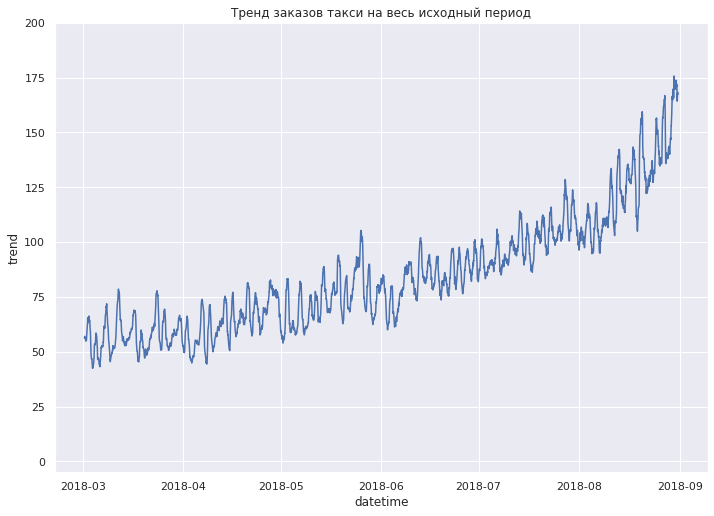

In [10]:
plt.ylim(-5,200)
plt.title("Тренд заказов такси на весь исходный период")
sns.lineplot(x=decomposed.trend.index, y=decomposed.trend, data=decomposed.trend);

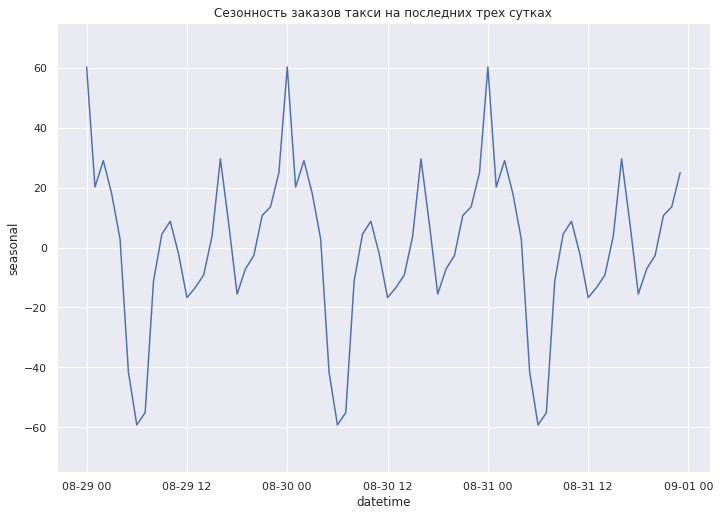

In [11]:
plt.ylim(-75,75)
plt.title("Сезонность заказов такси на последних трех сутках")
sns.lineplot(x=day_seasonal.index, y=day_seasonal, data=day_seasonal);

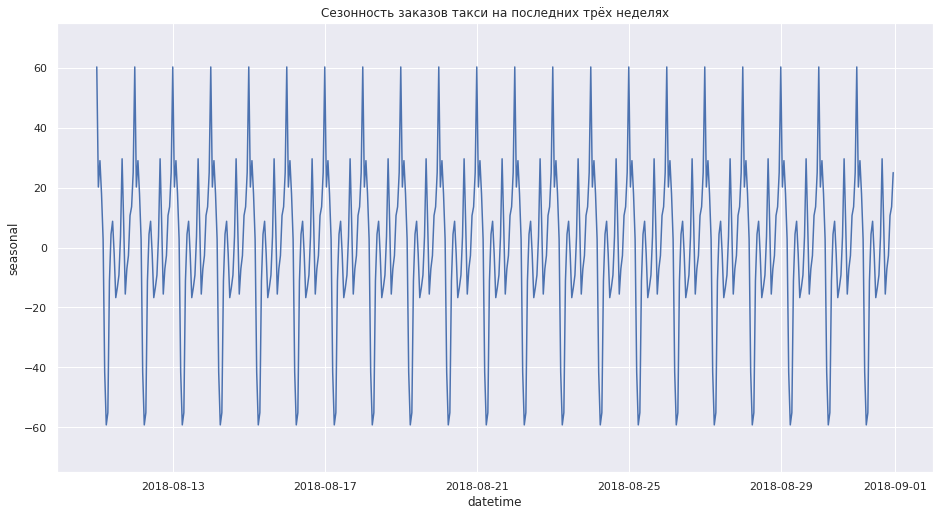

In [12]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
plt.ylim(-75,75)
plt.title("Сезонность заказов такси на последних трёх неделях")
sns.lineplot(x=week_seasonal.index, y=week_seasonal, data=week_seasonal);

Как и говорилось ранее, заметен положительный тренд с июля месяца. Наблюдается суточная сезонность, а также недельная.

## Подготовка признаков

Для дальнейшего построения моделей нам необходимо добавить признаки в нашу таблицу. Воспользуемся функцией:

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    
    '''Функция принимает на вход исходную таблицу, необходимое число лагов, а также окно для скользящего среднего.
    Возвращает датасет с новыми признаками.
    '''
    
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(df,168,5)

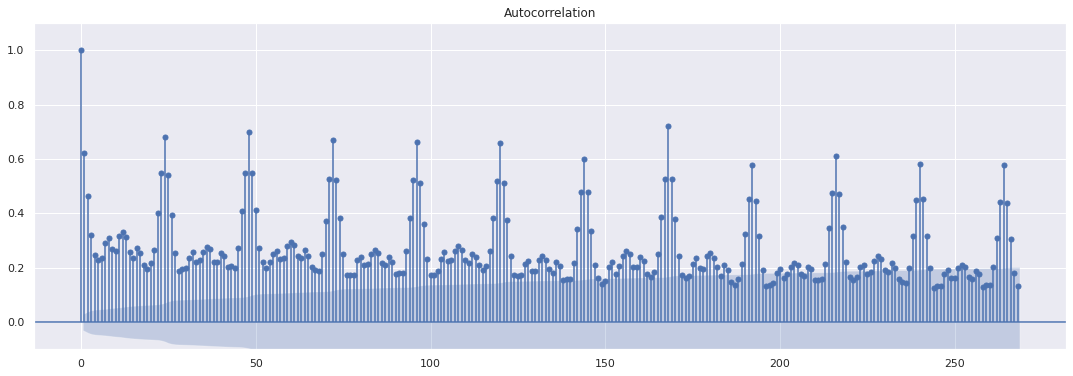

In [15]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 268)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [16]:
# Не забудем удалить Nan-значения
df.dropna(inplace=True)

In [17]:
df.head(5)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,91.0
2018-03-08 01:00:00,78,1,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,109.6
2018-03-08 02:00:00,65,2,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,110.0
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,101.4
2018-03-08 04:00:00,60,4,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,89.6


Далее выделим тренировочную, тестовую и валидационную выборки.

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
features_train, target_train = train.drop(columns=['num_orders']), train['num_orders']
features_test, target_test = test.drop(columns=['num_orders']), test['num_orders']

In [19]:
train_for_cat, valid_for_cat = train_test_split(train, shuffle=False, test_size=0.1)
features_train_cat, target_train_cat = train.drop(columns=['num_orders']), train['num_orders']
features_valid_cat, target_valid_cat = valid_for_cat.drop(columns=['num_orders']), valid_for_cat['num_orders']

In [20]:
display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(3823, 172)

(3823,)

(425, 172)

(425,)

Признаки подготовлены. Можно приступать к обучению моделей.

## Обучение

Мы обучим 4 модели:

- линейную регрессию с регуляризацией (Ridge)

- RandomForest

- Catboost

- Prophet

Далее выберем лучшую, протестировав на валидационной выборке.

### Ridge

In [21]:
model_ridge = Ridge(random_state=42)

In [22]:
tscv = TimeSeriesSplit(n_splits=10)

In [23]:
grid_search_model_ridge = GridSearchCV(model_ridge, {'alpha':[510,530,550]}, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

In [24]:
grid_search_model_ridge.fit(features_train, target_train)
grid_search_model_ridge.best_params_

{'alpha': 550}

In [25]:
model_ridge = Ridge(random_state=42, alpha=550)
model_ridge.fit(features_train, target_train)

Ridge(alpha=550, random_state=42)

In [26]:
print(f'Качество модели на валидационной выборке:\n{((grid_search_model_ridge.best_score_ * -1) ** 0.5).round(2)}')

Качество модели на валидационной выборке:
23.0


### RandomForest

In [83]:
tscv = TimeSeriesSplit(n_splits=3)

In [84]:
# Вариантов в параметрах было больше. Оставлены лучшие для ускорения выполнения ячейки

model_forest = RandomForestRegressor(random_state=42)
parametrs = {'n_estimators':[120,150,300], 
             'max_depth':[12,15,30]}
grid_search_model_forest = GridSearchCV(model_forest, parametrs, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

In [85]:
grid_search_model_forest.fit(features_train, target_train)
grid_search_model_forest.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [87]:
model_forest = RandomForestRegressor(random_state=42, max_depth=12, n_estimators=300)
model_forest.fit(features_train, target_train)

RandomForestRegressor(max_depth=12, n_estimators=300, random_state=42)

In [88]:
print(f'Качество модели на валидационной выборке:\n{((grid_search_model_forest.best_score_ * -1) ** 0.5).round(2)}')

Качество модели на валидационной выборке:
23.94


А теперь поглядим, как наши созданные признаки влияют на построение модели:

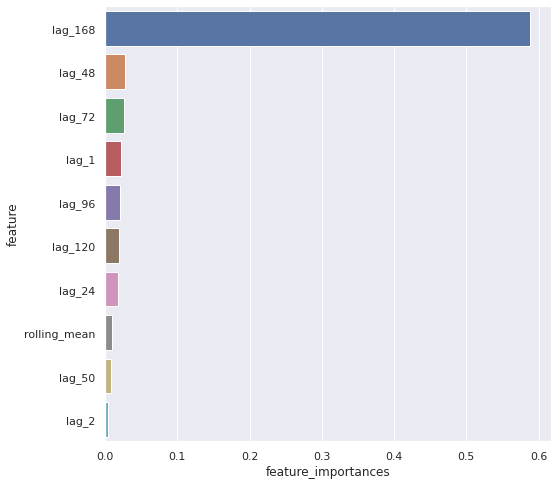

In [92]:
feature_importances = model_forest.feature_importances_
feature_importances_df = pd.DataFrame({'feature': list(features_train.columns),
                                      'feature_importances':feature_importances})
feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)[:10]
plt.figure(figsize=(8, 8))
sns.barplot(x=feature_importances_df.feature_importances, y=feature_importances_df.feature);

Как можно заметить, самый большой вклад вносит первый лаг. При этом совсем бесполезных фичей в нашей таблице не имеется.

### CatBoost

In [27]:
model_cat = CatBoostRegressor(loss_function="RMSE", iterations=10000, learning_rate=0.01, depth=4)

In [28]:
model_cat.fit(features_train_cat, target_train_cat, verbose=1, eval_set=(features_valid_cat, target_valid_cat))

0:	learn: 38.6455466	test: 55.8388226	best: 55.8388226 (0)	total: 72.9ms	remaining: 12m 9s
1:	learn: 38.4399266	test: 55.5551413	best: 55.5551413 (1)	total: 87.5ms	remaining: 7m 17s
2:	learn: 38.2459766	test: 55.3347840	best: 55.3347840 (2)	total: 102ms	remaining: 5m 38s
3:	learn: 38.0378840	test: 55.0816057	best: 55.0816057 (3)	total: 116ms	remaining: 4m 48s
4:	learn: 37.8456395	test: 54.8413469	best: 54.8413469 (4)	total: 130ms	remaining: 4m 19s
5:	learn: 37.6515036	test: 54.6083968	best: 54.6083968 (5)	total: 151ms	remaining: 4m 11s
6:	learn: 37.4563876	test: 54.3301137	best: 54.3301137 (6)	total: 168ms	remaining: 4m
7:	learn: 37.2866521	test: 54.1018106	best: 54.1018106 (7)	total: 181ms	remaining: 3m 46s
8:	learn: 37.0921243	test: 53.8572098	best: 53.8572098 (8)	total: 194ms	remaining: 3m 35s
9:	learn: 36.9275210	test: 53.6701209	best: 53.6701209 (9)	total: 207ms	remaining: 3m 27s
10:	learn: 36.7395464	test: 53.4337396	best: 53.4337396 (10)	total: 220ms	remaining: 3m 19s
11:	learn:

In [29]:
model_cat.get_best_score()

{'learn': {'RMSE': 8.926034948186361},
 'validation': {'RMSE': 5.923001061759862}}

In [30]:
cat_score = model_cat.get_best_score()['validation']['RMSE']

In [31]:
print(f'Качество модели на валидационной выборке:\n{cat_score}')

Качество модели на валидационной выборке:
5.923001061759862


### Prophet

Мы не проходили эту библиотеку на курсе, однако, я не могу оставить ее без внимания, так как она крутая и показывает очень неплохие результаты.

Таблицу для данной библиотеки надо привести к определенному виду.

In [32]:
df_prophet = df['num_orders'].reset_index()

In [33]:
df_prophet.columns = ['ds','y']

Выделим только тренировочную и тестовую выборки. Предварительную оценку проведем с помощью кросс-валидации.

In [34]:
df_prophet_train, df_prophet_test = df_prophet[:3965], df_prophet[3965:].set_index('ds')

In [35]:
# обучаем модель
m = Prophet()
m.fit(df_prophet_train)

15:48:50 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# с помощью встроенной функции делим трейн на 8 фолдов 
df_cv = cross_validation(m, horizon = '500 hours')

  0%|          | 0/8 [00:00<?, ?it/s]

15:48:56 - cmdstanpy - INFO - Chain [1] start processing
15:48:58 - cmdstanpy - INFO - Chain [1] done processing
15:48:58 - cmdstanpy - INFO - Chain [1] start processing
15:49:00 - cmdstanpy - INFO - Chain [1] done processing
15:49:00 - cmdstanpy - INFO - Chain [1] start processing
15:49:02 - cmdstanpy - INFO - Chain [1] done processing
15:49:02 - cmdstanpy - INFO - Chain [1] start processing
15:49:05 - cmdstanpy - INFO - Chain [1] done processing
15:49:05 - cmdstanpy - INFO - Chain [1] start processing
15:49:07 - cmdstanpy - INFO - Chain [1] done processing
15:49:07 - cmdstanpy - INFO - Chain [1] start processing
15:49:09 - cmdstanpy - INFO - Chain [1] done processing
15:49:09 - cmdstanpy - INFO - Chain [1] start processing
15:49:11 - cmdstanpy - INFO - Chain [1] done processing
15:49:11 - cmdstanpy - INFO - Chain [1] start processing
15:49:13 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# с помощью функции библиотеки получаем датасет с метриками
df_p = performance_metrics(df_cv)

In [38]:
prophet_score = df_p['rmse'].mean()

In [39]:
print(f'Качество модели на валидационной выборке:\n{prophet_score.round(2)}')

Качество модели на валидационной выборке:
28.2


## Тестирование

Прежде чем выбрать модель нужно выбрать также способ ее оценки. Выберем способ заполнения предсказанного значения предыдущим значением ряда. И сравним наши валидационные оценки с оценкой неадекватной модели.

In [42]:
pred_previous = target_valid_cat.shift(fill_value=target_train_cat.iloc[-1])

In [44]:
print(f'Качество случайной модели(предсказание на основе предыдущего значения):\n{((mean_squared_error(target_valid_cat,pred_previous))**0.5).round(2)}')

Качество случайной модели(предсказание на основе предыдущего значения):
47.62


Как видим, все наши модели получились адекватными. Но лучшие показатели у модели CatBoost. Ее и будем проверять на тестовой выборке.

In [47]:
cat_pred = model_cat.predict(features_test)

In [48]:
print(f'Качество модели на тестовой выборке:\n{((mean_squared_error(target_test,cat_pred))**0.5).round(2)}')

Качество модели на тестовой выборке:
37.36


Нам удалось добиться поставленной цели: модель выдает RMSE меньше 48 на тестовой выборке.

## Общий вывод

- На первом этапе работы мы загрузили данные, определили колонку с датами в качестве индекса, сделали проверку на правильную хронологию данных, а также проанализировали имеющиеся данные. В результате анализа было обнаружено, что в наших данных есть положительный тренд, который наблюдается в летние месяцы. Предварительно сформулирована причина такого тренда - повышенный спрос на авиаперелеты в сезон отпусков. Также была обнаружена суточная и недельная сезонности. Это помогло нам определиться с количеством лагов для наших данных.
    
---

- На втором этапе мы добавили признаки в нашу таблицу, а именно лаги (в количестве 168), скользящее среднее (значение окна 5), а также колонки со значением часа, дня и дня недели. Далее было проведено разделение выборки на тестовую (10%), валидационную (9%) и тренировочную.
    
---

- На этапе обучения моделей были выбраны 4 модели:
    
    - линейная регрессия с регуляризацией (Ridge)
    - RandomForest
    - Catboost
    - Prophet
    
    Лучший показатель на валидационной выборке был у модели Catboost. На втором месте модель Ridge.
    
---

- Далее мы провели сравнения показателя качества наших моделей с качеством неадекватной модели (которая делает предсказание на основе предыдущего значения). Все наши модели прошли проверку на адекватность.
    
---

- Для тестирования была выбрана модель Catboost. Она позволила добиться RMSE = 37.36. В требованиях заказчика данный показатель не должен превышать значение 48. Поставленной задачи добились.